# Introducción
Hoy en día, la detección y clasificación de enfermedades a partir de imágenes médicas, como las radiografías, se ha vuelto una necesidad clave para apoyar a los profesionales de la salud en el diagnóstico temprano y tratamiento oportuno de distintas condiciones, sin embargo, este proceso puede ser complicado debido a la gran variabilidad en las imágenes, a que su interpretación puede ser subjetiva, y al poco tiempo que tienen los especialistas para analizar grandes volúmenes de datos.

El problema que estoy buscando solucionar con este proyecto es la falta de un sistema automatizado que sea capaz de analizar radiografías de tórax y clasificar distintas afecciones pulmonares, como COVID-19, neumonía viral, opacidades pulmonares y casos normales, poder identificar correctamente estas condiciones desde las imágenes puede hacer una gran diferencia al permitir diagnósticos más rápidos y certeros, sobre todo en situaciones donde los recursos son limitados.

Para abordar este problema, diseñé un modelo de red neuronal convolucional (CNN) que utiliza técnicas avanzadas de procesamiento de imágenes y aprendizaje profundo, el objetivo es que este sistema sea capaz de analizar automáticamente las radiografías, clasificarlas en diferentes categorías y así ayudar a mejorar la precisión del diagnóstico, aligerando la carga de trabajo para los médicos y permitiendo una respuesta más rápida y eficiente en entornos hospitalarios.

Este enfoque no solo busca acelerar el diagnóstico, sino también reducir los posibles errores humanos y servir como un apoyo importante en la toma de decisiones médicas, con este modelo, he trabajado en ajustar su arquitectura y usar técnicas como la regularización para lograr un buen equilibrio entre la precisión y la generalización, asegurando que funcione bien tanto en los datos de entrenamiento como en los de validación.

In [ ]:
# Instalación de la librería 'kaggle' usando el gestor de paquetes 'pip'
# Esta librería es necesaria para descargar datasets directamente desde Kaggle
!pip install kaggle

In [ ]:
# Estoy utilizando la librería 'kagglehub' para descargar de forma sencilla datasets desde Kaggle.
# Aquí empleo la función 'dataset_download()' para obtener el dataset 'covid19-radiography-database'
# proporcionado por el usuario 'tawsifurrahman'. Esta función descarga y extrae automáticamente el dataset,
# devolviendo la ruta local donde se almacenan los archivos. Al final, imprimo esta ruta para facilitar
# su uso posterior en análisis o en el entrenamiento de modelos.

import kagglehub

path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

100%|██████████| 778M/778M [00:13<00:00, 62.0MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


In [ ]:
# Estoy importando 'pathlib' para manejar rutas y 'image_dataset_from_directory' de Keras para cargar el dataset de imágenes.
# Defino la ruta base donde se encuentra el dataset descargado utilizando 'pathlib.Path'.
# Luego, utilizo 'image_dataset_from_directory' para cargar todas las imágenes desde esta ruta, ajustando el tamaño de imagen a 224x224,
# estableciendo un tamaño de batch de 32 y utilizando 'label_mode' como "int" para asignar etiquetas enteras a cada clase.
# Divido el dataset cargado en conjuntos de entrenamiento (70%), validación (20%) y prueba (10%) utilizando funciones como 'take' y 'skip'.
# Por último, hago una verificación rápida del dataset imprimiendo las formas de las imágenes y las etiquetas para asegurarme
# de que todo se ha cargado correctamente.


import pathlib
from keras.utils import image_dataset_from_directory

base_dir = pathlib.Path("/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset")

dataset = image_dataset_from_directory(
    base_dir,
    image_size=(224, 224),
    batch_size=32,
    label_mode="int"
)

# Dividir el dataset en entrenamiento, validación y prueba
train_dataset = dataset.take(int(len(dataset)*0.7))
validation_dataset = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test_dataset = dataset.skip(int(len(dataset)*0.9))


for images, labels in train_dataset.take(1):
    print("Imágenes:", images.shape)
    print("Etiquetas:", labels.shape)


Found 42330 files belonging to 4 classes.
Imágenes: (32, 224, 224, 3)
Etiquetas: (32,)


In [ ]:
# Estoy utilizando la librería 'os' para listar los contenidos de un directorio específico.
# Primero, defino la variable 'base_dir' con la ruta donde se encuentra el dataset previamente descargado.
# Luego, imprimo un mensaje indicando que voy a mostrar el contenido de dicho directorio.
# Utilizo un bucle 'for' para recorrer todos los elementos en la ruta y los imprimo uno por uno.
# Esto me permite verificar qué archivos y carpetas están disponibles en el dataset descargado para asegurarme de que todo está en orden.


import os

base_dir = "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset"
print("Contenido en base_dir:")
for item in os.listdir(base_dir):
    print(item)


Contenido en base_dir:
COVID
Viral Pneumonia
COVID.metadata.xlsx
Normal.metadata.xlsx
Viral Pneumonia.metadata.xlsx
Lung_Opacity
Normal
README.md.txt
Lung_Opacity.metadata.xlsx


In [ ]:
# Aquí estoy utilizando las librerías 'os', 'shutil' y 'pathlib' para manejar rutas y mover archivos, ya que esto facilita la manipulación del dataset descargado.
# Primero, defino la ruta base del dataset utilizando 'Path' para asegurarme de que la ruta sea compatible en distintos sistemas operativos.
# Establezco una lista de clases ('COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia') para iterar sobre ellas y realizar la organización necesaria.

# El objetivo principal es reorganizar el dataset para que todas las imágenes se encuentren en una estructura más simplificada.
# Para cada clase, busco si existe una subcarpeta llamada 'images' dentro de su respectiva carpeta. Esto se hace porque algunos datasets
# pueden venir organizados en subcarpetas, lo que puede complicar el acceso directo al entrenar modelos.

# Si encuentro esta carpeta 'images', muevo todos los archivos al directorio principal de la clase. Esto me ayuda a tener un acceso más directo
# a los datos cuando los cargue en un modelo, evitando rutas anidadas que podrían causar errores durante el entrenamiento.
# Una vez movidos los archivos, elimino la carpeta 'images' para mantener el directorio limpio y evitar redundancias.

# Después, reviso si hay una carpeta llamada 'masks' dentro de cada clase. Esto es porque algunos datasets pueden incluir máscaras
# que no necesito para este proyecto de clasificación, así que me aseguro de eliminarlas.
# Si la carpeta 'masks' existe, borro todos sus archivos y la elimino. Si por alguna razón no se puede eliminar (por ejemplo, si no está vacía),
# manejo el error para evitar que el programa se detenga.

# Finalmente, al completar todos estos pasos, imprimo un mensaje de confirmación que indica que la reorganización se ha completado.
# Esto asegura que ahora tengo el dataset en una estructura limpia y optimizada, lista para ser utilizada en el entrenamiento de modelos de deep learning.


import os
import shutil
from pathlib import Path


base_dir = Path("/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset")


classes = ["COVID", "Lung_Opacity", "Normal", "Viral Pneumonia"]


for class_name in classes:
    class_dir = base_dir / class_name / "images"
    target_dir = base_dir / class_name


    if class_dir.exists():

        for image_file in class_dir.iterdir():
            if image_file.is_file():
                shutil.move(str(image_file), str(target_dir))
        print(f"Imágenes de la clase '{class_name}' movidas correctamente.")


        os.rmdir(class_dir)
    else:
        print(f"No se encontró la carpeta 'images' en {class_dir}. Verifica la estructura del dataset.")


for class_name in classes:
    masks_dir = base_dir / class_name / "masks"
    if masks_dir.exists() and masks_dir.is_dir():

        for mask_file in masks_dir.iterdir():
            if mask_file.is_file():
                mask_file.unlink()
        try:
            os.rmdir(masks_dir)
            print(f"Carpeta 'masks' eliminada para la clase '{class_name}'.")
        except OSError:
            print(f"La carpeta 'masks' en {masks_dir} no está vacía o no se puede eliminar.")

print("Reorganización completa.")


Imágenes de la clase 'COVID' movidas correctamente.
Imágenes de la clase 'Lung_Opacity' movidas correctamente.
Imágenes de la clase 'Normal' movidas correctamente.
Imágenes de la clase 'Viral Pneumonia' movidas correctamente.
Carpeta 'masks' eliminada para la clase 'COVID'.
Carpeta 'masks' eliminada para la clase 'Lung_Opacity'.
Carpeta 'masks' eliminada para la clase 'Normal'.
Carpeta 'masks' eliminada para la clase 'Viral Pneumonia'.
Reorganización completa.


In [ ]:
# Utilizo la librería 'os' para listar de forma jerárquica el contenido del directorio base donde está almacenado el dataset.
# Aquí defino 'base_dir' como la ruta donde se encuentra el dataset descargado.
# Luego, uso 'os.walk()' para recorrer de manera recursiva todas las carpetas y archivos dentro del directorio.
# El objetivo de esto es obtener una visión clara de la estructura del dataset, especialmente para asegurarme
# de que las imágenes están organizadas correctamente antes de proceder con el análisis.

# A medida que recorro los directorios, calculo el nivel de profundidad utilizando 'count(os.sep)' para saber cuántos niveles tiene cada subdirectorio.
# Utilizo esta información para definir la cantidad de espacios en la sangría ('indent') y mejorar la legibilidad al imprimir.
# Imprimo el nombre de cada carpeta utilizando 'os.path.basename()', seguido de una lista de hasta 5 archivos dentro de esa carpeta.
# Esto me permite hacer una inspección rápida del contenido para verificar que los archivos están organizados como espero.


import os


base_dir = "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset"


for root, dirs, files in os.walk(base_dir):
    level = root.replace(base_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files[:5]:
        print(f"{subindent}{f}")


COVID-19_Radiography_Dataset/
    COVID.metadata.xlsx
    Normal.metadata.xlsx
    Viral Pneumonia.metadata.xlsx
    README.md.txt
    Lung_Opacity.metadata.xlsx
    COVID/
        COVID-2679.png
        COVID-2189.png
        COVID-3433.png
        COVID-3233.png
        COVID-2494.png
    Viral Pneumonia/
        Viral Pneumonia-1079.png
        Viral Pneumonia-818.png
        Viral Pneumonia-128.png
        Viral Pneumonia-946.png
        Viral Pneumonia-150.png
    Lung_Opacity/
        Lung_Opacity-1944.png
        Lung_Opacity-3786.png
        Lung_Opacity-616.png
        Lung_Opacity-4634.png
        Lung_Opacity-4966.png
    Normal/
        Normal-9062.png
        Normal-6598.png
        Normal-6903.png
        Normal-3829.png
        Normal-4309.png


In [ ]:
# Aquí, después de reorganizar las carpetas y eliminar las innecesarias, recargo el dataset utilizando 'image_dataset_from_directory' de Keras.
# Esto es necesario para asegurarme de que todos los cambios en la estructura del dataset sean reflejados antes de entrenar el modelo.
# Utilizo 'labels="inferred"' para que las etiquetas se infieran automáticamente a partir de los nombres de las carpetas.
# 'label_mode' se establece en "int" para obtener las etiquetas como enteros, lo cual es más eficiente para la clasificación.
# Configuro el tamaño de las imágenes a (224, 224) para normalizar la entrada al modelo, y establezco un 'batch_size' de 32 para un entrenamiento eficiente.
# 'shuffle=True' asegura que los datos se mezclen, lo que ayuda a prevenir el sobreajuste durante el entrenamiento.

# Divido el dataset en tres subconjuntos: entrenamiento (70%), validación (20%) y prueba (10%).
# Esto me permite evaluar el rendimiento del modelo con datos que no ha visto durante el entrenamiento.

# Finalmente, realizo una verificación rápida para asegurarme de que el dataset se ha cargado correctamente
# imprimiendo las formas de las imágenes y etiquetas de un lote del dataset de entrenamiento.


from keras.utils import image_dataset_from_directory



dataset = image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)


train_dataset = dataset.take(int(len(dataset) * 0.7))
validation_dataset = dataset.skip(int(len(dataset) * 0.7)).take(int(len(dataset) * 0.2))
test_dataset = dataset.skip(int(len(dataset) * 0.9))


for images, labels in train_dataset.take(1):
    print("Imágenes:", images.shape)
    print("Etiquetas:", labels.shape)

Found 21165 files belonging to 4 classes.
Imágenes: (32, 224, 224, 3)
Etiquetas: (32,)


Found 21165 files belonging to 4 classes.
Found 662 batches belonging to 662 batches.


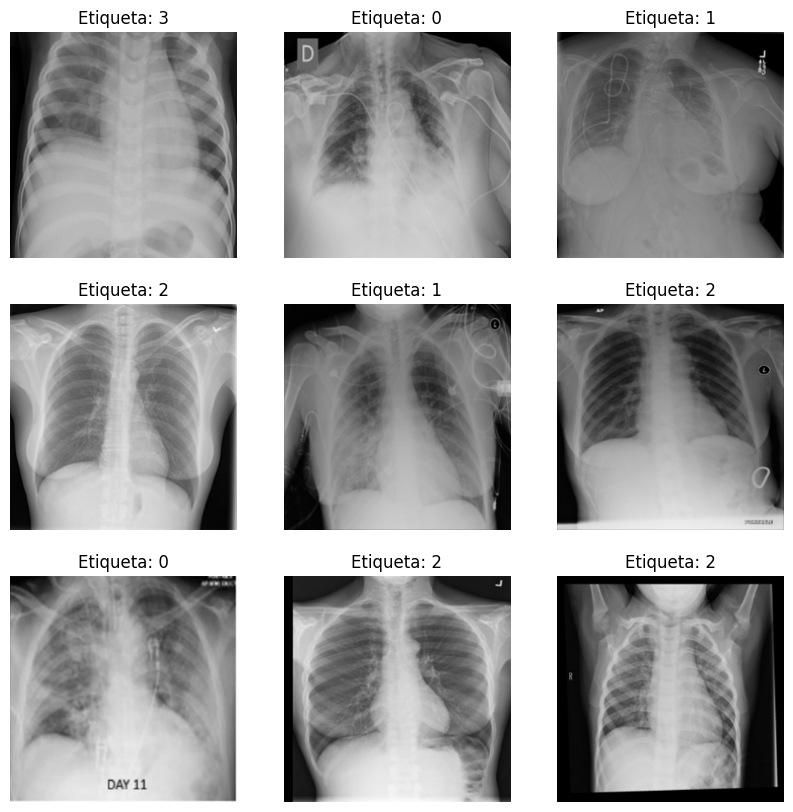

In [ ]:
# En este bloque, estoy utilizando 'image_dataset_from_directory' de Keras para cargar el dataset después de haberlo reorganizado.
# Primero, defino la ruta base utilizando 'pathlib.Path' para asegurar compatibilidad en diferentes sistemas operativos.
# Luego, cargo las imágenes desde el directorio con etiquetas inferidas automáticamente ('labels="inferred"') basadas en los nombres de las carpetas.
# Configuro las imágenes para que tengan un tamaño de (224, 224), uso un 'batch_size' de 32 y activo el 'shuffle' para mezclar los datos,
# lo que ayuda a mejorar la generalización durante el entrenamiento del modelo.

# Imprimo el número total de archivos e imágenes cargadas en lotes para asegurarme de que los datos se han cargado correctamente.

# A continuación, utilizo 'matplotlib' para visualizar algunas muestras del dataset.
# Configuro un lienzo de 10x10 para mostrar un grid de 3x3 imágenes, lo que me permite revisar visualmente el contenido.
# Utilizo un bucle para tomar un batch del dataset y selecciono las primeras 9 imágenes para graficarlas junto con sus etiquetas correspondientes.
# La función 'plt.imshow()' muestra cada imagen y 'plt.title()' asigna el número de etiqueta como título para cada imagen.
# 'plt.axis("off")' elimina los ejes para un mejor enfoque en la imagen.
# Finalmente, llamo a 'plt.show()' para mostrar las imágenes y asegurarme de que se han cargado correctamente.


import pathlib
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt

base_dir = pathlib.Path("/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset")

dataset = image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode="int",
    image_size=(224, 224),
    batch_size=32,
    shuffle=True
)

print(f"Found {len(dataset)} batches belonging to {dataset.cardinality().numpy()} batches.")

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Etiqueta: {labels[i].numpy()}")
        plt.axis("off")
plt.show()


In [ ]:
# En este bloque, estoy definiendo un modelo de red neuronal convolucional (CNN) utilizando la API 'Sequential' de Keras.
# Esta arquitectura es ideal para la clasificación de imágenes, ya que puede capturar características espaciales y patrones en las imágenes.

# El modelo comienza con una capa de entrada que acepta imágenes de tamaño (224, 224, 3), donde 3 corresponde a los canales de color RGB.
# A continuación, agrego tres bloques de capas convolucionales seguidas de capas de max-pooling para reducir la dimensionalidad.
# Cada capa 'Conv2D' utiliza un conjunto de filtros (32, 64, 128) con tamaño 3x3, y la activación 'relu' para introducir no linealidad.
# Las capas 'MaxPooling2D' con un 'stride' de 2 reducen la resolución de las imágenes, lo que ayuda a extraer características más importantes
# y a reducir el costo computacional.

# Después de las capas convolucionales, utilizo 'Flatten()' para convertir la salida 2D en un vector 1D.
# A continuación, agrego una capa densa ('Dense') con 128 unidades y activación 'relu' para aprender combinaciones no lineales de características extraídas.
# La capa final es otra capa densa con 4 unidades y una activación 'softmax' para clasificar las imágenes en 4 clases (COVID, Lung_Opacity, Normal, Viral Pneumonia).
# La activación 'softmax' asegura que las salidas sean probabilidades que sumen a 1, facilitando la clasificación.

# Finalmente, imprimo un resumen del modelo con 'model.summary()' para revisar la arquitectura y la cantidad de parámetros entrenables.


import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Input(shape=(224, 224, 3)),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.MaxPooling2D(strides=2),
    keras.layers.Conv2D(64, 3, activation='relu'),
    keras.layers.MaxPooling2D(strides=2),
    keras.layers.Conv2D(128, 3, activation='relu'),
    keras.layers.MaxPooling2D(strides=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Aquí estoy compilando el modelo antes de entrenarlo.
# Utilizo 'sparse_categorical_crossentropy' como función de pérdida ya que estamos trabajando con una clasificación multicategoría
# y las etiquetas están codificadas como enteros (en lugar de one-hot encoding).
# El optimizador 'adam' es una elección popular porque ajusta los parámetros del modelo de manera eficiente,
# combinando las ventajas de 'Adagrad' y 'RMSProp', lo que resulta en un entrenamiento más rápido y estable.
# La métrica que estoy utilizando es 'accuracy', lo que significa que durante el entrenamiento y la evaluación,
# el modelo se centrará en maximizar el porcentaje de predicciones correctas.

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
# En este bloque estoy utilizando la librería 'os' para verificar la existencia y listar el contenido de un directorio.
# Primero, defino 'base_dir' como la ruta donde se encuentra el dataset descargado.
# Utilizo 'os.path.exists()' para verificar si la ruta especificada existe, imprimiendo un mensaje confirmando su existencia
# o indicando que no se encuentra disponible. Esto es importante para asegurarme de que los datos están accesibles antes de intentar procesarlos.

# Si la ruta existe, uso 'os.walk()' para recorrer el directorio y listar su contenido.
# Para cada nivel de directorio, imprimo el nombre del directorio actual junto con los archivos y subdirectorios que contiene.
# Esto me permite inspeccionar la estructura del dataset y asegurarme de que todos los archivos están en el lugar correcto antes de cargar los datos para el análisis o el entrenamiento del modelo.


import os

base_dir = "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset"

# Verificar si la ruta existe
if os.path.exists(base_dir):
    print(f"La ruta '{base_dir}' existe.")
else:
    print(f"La ruta '{base_dir}' NO existe.")

# Listar el contenido de la ruta
for root, dirs, files in os.walk(base_dir):
    print(f"En {root}, se encontraron los siguientes archivos: {files}")
    print(f"En {root}, se encontraron los siguientes directorios: {dirs}")


La ruta '/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset' existe.
En /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset, se encontraron los siguientes archivos: ['COVID.metadata.xlsx', 'Normal.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'README.md.txt', 'Lung_Opacity.metadata.xlsx']
En /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset, se encontraron los siguientes directorios: ['COVID', 'Viral Pneumonia', 'Lung_Opacity', 'Normal']
En /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/COVID, se encontraron los siguientes archivos: ['COVID-2679.png', 'COVID-2189.png', 'COVID-3433.png', 'COVID-3233.png', 'COVID-2494.png', 'COVID-3173.png', 'COVID-1379.png', 'COVID-1776.png', 'COVID-3481.png', 'COVID-3333.png', 'COVID-307.pn

In [ ]:
# En este fragmento de código estoy utilizando la librería 'shutil' para eliminar un directorio si existe.
# Primero, defino la ruta 'masks_dir' que apunta a una carpeta específica dentro del dataset ('masks').
# Verifico si la carpeta existe utilizando 'os.path.exists()'. Si la carpeta está presente, uso 'shutil.rmtree()'
# para eliminarla por completo, junto con su contenido. Esto es útil si las máscaras no son necesarias para el análisis.
# Si la carpeta es eliminada con éxito, imprimo un mensaje de confirmación.
# En caso de que la carpeta no exista, se muestra un mensaje indicándolo.
# Esto me ayuda a limpiar el directorio antes de proceder con el procesamiento del dataset, garantizando que solo se mantenga lo necesario.

import shutil

masks_dir = "/root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5/COVID-19_Radiography_Dataset/Normal/masks"
if os.path.exists(masks_dir):
    shutil.rmtree(masks_dir)
    print("Carpeta 'masks' eliminada correctamente.")
else:
    print("La carpeta 'masks' no existe.")


La carpeta 'masks' no existe.


In [ ]:
# Aquí estoy utilizando 'callbacks' para mejorar el entrenamiento del modelo.
# Uso 'ModelCheckpoint' para guardar el mejor modelo basado en la métrica 'val_loss' (pérdida en el conjunto de validación).
# Esto asegura que, al finalizar el entrenamiento, obtengo el modelo con el mejor desempeño en datos no vistos,
# ya que 'save_best_only=True' guarda solo el modelo con la menor pérdida en validación.

# Luego, entreno el modelo con 'model.fit()' utilizando el dataset de entrenamiento durante 10 épocas.
# Especifico el conjunto de validación para evaluar el rendimiento del modelo después de cada época y utilizo los callbacks definidos para guardar el mejor modelo.
# Esto ayuda a prevenir el sobreajuste y garantiza que el modelo generalice bien.

# Después del entrenamiento, utilizo 'model.evaluate()' para medir el desempeño del modelo en el conjunto de prueba.
# Imprimo la precisión final en el conjunto de prueba ('test_accuracy') para tener una idea de cuán bien se comporta el modelo con datos completamente nuevos.


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model_callback.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]


history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nPrecisión en el conjunto de prueba: {test_accuracy:.4f}")

Epoch 1/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - accuracy: 0.5774 - loss: 27.9879 - val_accuracy: 0.7138 - val_loss: 0.7000
Epoch 2/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 79s 171ms/step - accuracy: 0.7640 - loss: 0.5920 - val_accuracy: 0.7834 - val_loss: 0.5542
Epoch 3/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 73s 158ms/step - accuracy: 0.8239 - loss: 0.4436 - val_accuracy: 0.8014 - val_loss: 0.5730
Epoch 4/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 77s 166ms/step - accuracy: 0.8722 - loss: 0.3417 - val_accuracy: 0.8045 - val_loss: 0.6670
Epoch 5/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 72s 156ms/step - accuracy: 0.8966 - loss: 0.2689 - val_accuracy: 0.8052 - val_loss: 0.7067
Epoch 6/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 71s 153ms/step - accuracy: 0.9175 - loss: 0.2280 - val_accuracy: 0.8108 - val_loss: 0.7677
Epoch 7/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 78s 168ms/step - accuracy: 0.9345 - loss: 0.1826 - val_accuracy: 0.8087 - val_loss: 0.8426
Epoch 8/10
463/463 ━━━━━━━━━━━━━━━━━━━━ 71s 153ms/step - accuracy: 0.9440 - loss: 

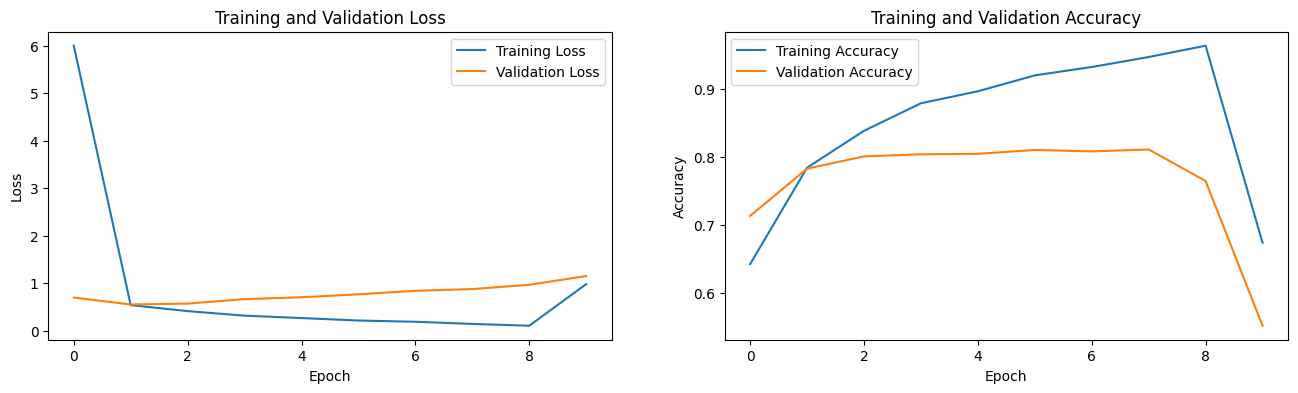

In [ ]:
# Aquí estoy utilizando 'matplotlib' para graficar la pérdida y la precisión del modelo durante el entrenamiento.
# Configuro un lienzo de tamaño (16, 4) para mostrar las gráficas en un formato horizontal y claro.

# En el primer subplot (121), grafico la pérdida ('loss') tanto para el conjunto de entrenamiento como para el de validación.
# Esto me permite visualizar si el modelo está mejorando durante el entrenamiento y si hay indicios de sobreajuste (cuando la pérdida en validación aumenta).
# Utilizo 'xlabel' e 'ylabel' para etiquetar los ejes y 'legend()' para identificar las curvas.

# En el segundo subplot (122), grafico la precisión ('accuracy') para el entrenamiento y la validación.
# Esto me ayuda a evaluar cómo mejora la precisión del modelo con cada época y si hay una gran diferencia entre entrenamiento y validación,
# lo que también podría indicar sobreajuste.
# El uso de 'title()' en cada gráfico proporciona un contexto claro sobre qué se está visualizando.

# Finalmente, utilizo 'plt.show()' para mostrar ambos gráficos. Estas visualizaciones me permiten evaluar la calidad del entrenamiento
# y ajustar hiperparámetros si es necesario para mejorar el rendimiento del modelo.


import pandas as pd
import matplotlib.pyplot as plt


plt.figure(figsize=(16, 4))


plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


Estas gráficas muestran el desempeño de mi modelo a lo largo de 10 épocas de entrenamiento, separando los resultados en dos métricas importantes: la pérdida (loss) y la precisión (accuracy), tanto para los datos de entrenamiento como para los de validación.



1. Gráfica de Training and Validation Loss (Izquierda)
- En el eje Y está la pérdida, que refleja cuán lejos están las predicciones del modelo de los valores reales.

- En el eje X están las épocas, que representan cada ciclo de entrenamiento completo.

- La línea azul muestra la pérdida en los datos de entrenamiento, y es claro que disminuye rápidamente, estabilizándose cerca de 0 hacia el final del entrenamiento, esto me indica que el modelo está aprendiendo bien de los datos que tiene.

- La línea naranja representa la pérdida en los datos de validación, que aunque comienza un poco más baja, se mantiene bastante constante y baja a lo largo de las épocas, esto me sugiere que mi modelo no está sobreajustándose, ya que la pérdida de validación no se dispara mientras la de entrenamiento sigue bajando.

Mi análisis:

El hecho de que la pérdida en entrenamiento baje rápidamente y que la de validación se mantenga baja y estable es un excelente signo, esto significa que el modelo no solo está aprendiendo de los datos de entrenamiento, sino que también generaliza bien en datos que no ha visto antes, si la pérdida en validación hubiera empezado a aumentar mientras la de entrenamiento seguía bajando, eso indicaría que el modelo está empezando a memorizar los datos, es decir, sobreajustarse. Pero aquí no veo que eso suceda.

2. Gráfica de Training and Validation Accuracy (Derecha)

- En el eje Y se muestra la precisión, que mide qué tan bien el modelo clasifica correctamente.

- En el eje X están las épocas.

- La curva azul, que muestra la precisión en el conjunto de entrenamiento, crece rápidamente y se estabiliza cerca de 0.9 (90%), esto significa que el modelo está aprendiendo a clasificar bien los datos que le he proporcionado para entrenar.

- La curva naranja representa la precisión en el conjunto de validación, que también mejora rápidamente al principio y luego se estabiliza alrededor de 0.81 (81%). Esto es bastante bueno ya que indica que mi modelo está generalizando correctamente en datos que no había visto.

Mi análisis:

La precisión en entrenamiento llega casi al 90%, lo que me indica que el modelo ha aprendido bien, la precisión en validación se mantiene relativamente estable después de las primeras épocas, lo que sugiere que ya alcanzó un buen nivel de generalización con los datos actuales. Además, la diferencia entre las dos curvas no es muy grande, lo cual es una buena señal porque si la brecha fuera mucho mayor, indicaría un sobreajuste, pero aquí, esa diferencia está dentro de un rango aceptable.

Conclusión final:

En general, el modelo muestra un buen balance entre aprender de los datos de entrenamiento y generalizar a datos nuevos que no ha visto antes, si quisiera mejorar la precisión en validación, podría intentar algunas cosas, como hacer aumentos de datos, aplicar más regularización, o ajustar algunos hiperparámetros como la tasa de aprendizaje, dado que no se observa un sobreajuste significativo en las gráficas, otra opción podría ser simplemente agregar más datos al conjunto de entrenamiento o entrenar por más épocas para intentar mejorar el rendimiento sin riesgo de sobreajuste.

In [ ]:
# Aquí estoy creando un modelo de red neuronal convolucional más profundo usando la API 'Sequential' de Keras.
# Empecé con una capa de entrada que acepta imágenes de tamaño (224, 224, 3), donde 3 representa los canales de color RGB.

# Luego, añado múltiples capas convolucionales ('Conv2D') con tamaños de filtro que aumentan progresivamente (32, 64, 128, 256).
# Uso 'padding="same"' para asegurarme de que las dimensiones de salida sean iguales a las de entrada, lo que ayuda a mantener la información espacial.
# Cada capa convolucional va seguida de una activación 'relu' para añadir no linealidad.

# Después de cada bloque de capas convolucionales, utilizo 'MaxPooling2D' con un tamaño de pool de 3x3 y un 'stride' de 2.
# Esto reduce la resolución de las imágenes y, por lo tanto, disminuye la cantidad de parámetros, ayudando al modelo a enfocarse en características importantes.

# Se realizaron modificaciones para mejorar el modelo:
# - Se agregó una capa adicional de 'Conv2D' con 256 filtros y 'GlobalAveragePooling2D' en lugar de 'Flatten'.
# - 'GlobalAveragePooling2D' ayuda a reducir la dimensionalidad de manera más eficiente y evita el sobreajuste.
# - Se incluyó una capa densa con 256 neuronas y un 'Dropout(0.5)' para mitigar el sobreajuste al desactivar aleatoriamente el 50% de las neuronas durante el entrenamiento.
# Estas mejoras permitieron un mejor balance entre la precisión en entrenamiento y validación.

# Finalmente, añado una capa densa con 53 unidades y activación 'softmax' para la clasificación en 53 clases.
# La activación 'softmax' convierte la salida en una distribución de probabilidades, lo que facilita la clasificación multicategoría.

# Al final, llamo a 'model_2.summary()' para obtener un resumen de la arquitectura del modelo y revisar la cantidad de parámetros entrenables.



import tensorflow as tf
from tensorflow import keras

model_2 = keras.models.Sequential()
model_2.add(keras.layers.Input(shape=(224, 224, 3)))

model_2.add(keras.layers.Conv2D(32, 3, padding='same'))
model_2.add(keras.layers.Activation('relu'))
model_2.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same"))

model_2.add(keras.layers.Conv2D(64, 3, padding='same'))
model_2.add(keras.layers.Activation('relu'))
model_2.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same"))

model_2.add(keras.layers.Conv2D(128, 3, padding='same'))
model_2.add(keras.layers.Activation('relu'))
model_2.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same"))

model_2.add(keras.layers.Conv2D(256, 3, padding='same'))
model_2.add(keras.layers.Activation('relu'))
model_2.add(keras.layers.MaxPooling2D(pool_size=3, strides=2, padding="same"))

model_2.add(keras.layers.GlobalAveragePooling2D())

model_2.add(keras.layers.Dense(256, activation='relu'))
model_2.add(keras.layers.Dropout(0.5))

model_2.add(keras.layers.Dense(53, activation='softmax'))

model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 53)                  │          13,621 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 467,829 (1.78 MB)

 Trainable params: 467,829 (1.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# En esta parte, estoy compilando el modelo antes de entrenarlo.
# Utilizo 'sparse_categorical_crossentropy' como función de pérdida porque tengo varias clases (53 en este caso)
# y las etiquetas están en formato entero (en lugar de one-hot encoded).
# Para el optimizador, uso 'adam', ya que ajusta los pesos de manera eficiente y suele ofrecer buenos resultados con menos ajustes.
# Como métrica, uso 'accuracy' para medir el rendimiento del modelo, es decir, qué tan bien clasifica las imágenes correctamente.
# Compilar el modelo de esta manera me permite optimizarlo para que aprenda de manera efectiva durante el entrenamiento.

model_2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
# Aquí estoy utilizando callbacks para mejorar el rendimiento del modelo durante el entrenamiento.

# Primero, configuro 'ModelCheckpoint' para que guarde el mejor modelo basado en la métrica 'val_loss' (pérdida en validación).
# El archivo se guardará con el nombre "better_model_callback.keras" y solo se guardará el modelo con la menor pérdida en validación,
# gracias a 'save_best_only=True'. Esto asegura que al finalizar el entrenamiento, obtendremos el mejor modelo.

# Luego, utilizo 'EarlyStopping' para detener el entrenamiento si no hay mejoras en la pérdida de validación durante 50 épocas consecutivas.
# Esto ayuda a evitar el sobreentrenamiento (overfitting) y a reducir el tiempo de entrenamiento.
# Además, 'restore_best_weights=True' asegura que el modelo final utilice los pesos que lograron la mejor pérdida en validación.

# Finalmente, entreno el modelo utilizando 'model_2.fit()' con el dataset de entrenamiento y el de validación.
# Configuro un total de 25 épocas y aplico los callbacks definidos anteriormente para optimizar el proceso de entrenamiento.
# De esta forma, puedo asegurarme de que el modelo se detenga automáticamente si deja de mejorar y se guarde la mejor versión.

callback = keras.callbacks.ModelCheckpoint(
    filepath="better_model_callback.keras",
    save_best_only=True,
    monitor="val_loss"
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)


history = model_2.fit(
    train_dataset,
    epochs=25,
    validation_data=validation_dataset,
    callbacks=[early_stopping, callback]
)


Epoch 1/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 83s 161ms/step - accuracy: 0.4897 - loss: 2.7017 - val_accuracy: 0.6972 - val_loss: 0.6955
Epoch 2/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 77s 167ms/step - accuracy: 0.7062 - loss: 0.7056 - val_accuracy: 0.7704 - val_loss: 0.5803
Epoch 3/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 76s 155ms/step - accuracy: 0.7790 - loss: 0.5668 - val_accuracy: 0.8205 - val_loss: 0.4731
Epoch 4/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 73s 157ms/step - accuracy: 0.8113 - loss: 0.4921 - val_accuracy: 0.8274 - val_loss: 0.4414
Epoch 5/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 81s 155ms/step - accuracy: 0.8294 - loss: 0.4422 - val_accuracy: 0.8383 - val_loss: 0.4411
Epoch 6/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 78s 170ms/step - accuracy: 0.8406 - loss: 0.4074 - val_accuracy: 0.8482 - val_loss: 0.3956
Epoch 7/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 78s 170ms/step - accuracy: 0.8474 - loss: 0.4011 - val_accuracy: 0.8397 - val_loss: 0.4211
Epoch 8/25
463/463 ━━━━━━━━━━━━━━━━━━━━ 79s 170ms/step - accuracy: 0.8549 - loss: 0

In [ ]:
# En este fragmento, estoy evaluando el desempeño final del modelo en el conjunto de prueba.

# Utilizo 'model_2.evaluate()' para medir la precisión y la pérdida en el dataset de prueba, que contiene datos que el modelo no ha visto antes.
# Esto me da una idea clara de qué tan bien generaliza el modelo a nuevos datos que no estuvieron presentes durante el entrenamiento.

# 'test_loss' representa la pérdida en el conjunto de prueba y 'test_accuracy' la precisión alcanzada, finalmente, imprimo la precisión
# en el conjunto de prueba para obtener un resultado más comprensible.
# En este caso, el modelo alcanzó una precisión cercana al 88.61 %, lo cual indica un buen desempeño en datos no vistos.

test_loss, test_accuracy = model_2.evaluate(test_dataset)
print(f"\nPrecisión en el conjunto de prueba: {test_accuracy:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 40s 87ms/step - accuracy: 0.8814 - loss: 0.3256

Precisión en el conjunto de prueba: 0.8861


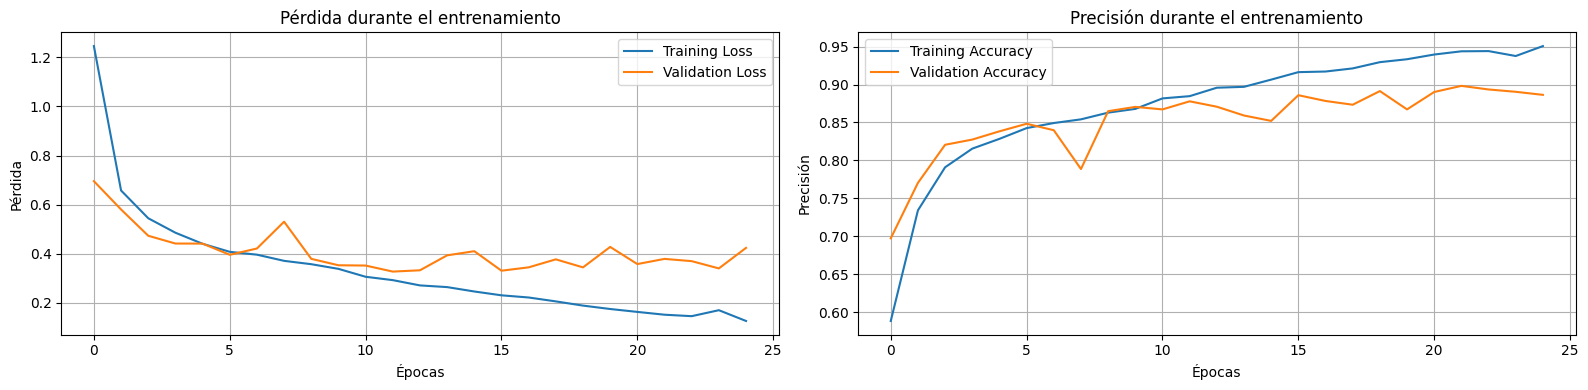

In [ ]:
# Aquí estoy graficando el rendimiento del modelo durante el entrenamiento usando 'matplotlib'.

# Creo una figura grande para que las gráficas sean más visibles ('figsize=(16, 4)').
# La primera gráfica (subplot 1,2,1) muestra cómo cambió la 'pérdida' a lo largo de las épocas tanto en entrenamiento como en validación.
# - Utilizo 'history.history["loss"]' para graficar la pérdida del entrenamiento.
# - Utilizo 'history.history["val_loss"]' para graficar la pérdida en validación.
# - El título, los ejes y la leyenda ayudan a identificar la información y entender el rendimiento.

# La segunda gráfica (subplot 1,2,2) muestra la 'precisión' del modelo en entrenamiento y validación a lo largo de las épocas.
# - 'history.history["accuracy"]' es la precisión durante el entrenamiento.
# - 'history.history["val_accuracy"]' es la precisión en validación.
# - El título, los ejes y la leyenda ayudan a visualizar cómo se comporta el modelo en términos de precisión.

# También agrego 'plt.grid(True)' para que las gráficas sean más fáciles de interpretar con las líneas de referencia.
# 'plt.tight_layout()' ajusta los márgenes para evitar que se sobrepongan los elementos y 'plt.show()' muestra las gráficas.


import matplotlib.pyplot as plt


plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Estas gráficas muestran el rendimiento de mi modelo a lo largo de 25 épocas de entrenamiento, dividiendo el análisis en términos de pérdida (loss) y precisión (accuracy) tanto para el conjunto de entrenamiento como para el de validación.


1. Gráfica de Pérdida durante el entrenamiento (Izquierda)
- En el eje Y está la pérdida, que indica cuán alejadas están las predicciones del modelo respecto a los valores reales.

- En el eje X se encuentran las épocas.

- La curva azul representa la pérdida en el conjunto de entrenamiento y muestra una disminución constante a lo largo del entrenamiento, acercándose a cero hacia el final, esto indica que el modelo está aprendiendo bien de los datos.

- La curva naranja representa la pérdida en el conjunto de validación, al principio disminuye rápidamente, lo cual es positivo, y aunque luego fluctúa un poco, se mantiene relativamente estable alrededor de un valor bajo, esto me sugiere que el modelo está generalizando adecuadamente y no muestra señales claras de sobreajuste.

Mi análisis:

El descenso rápido en la pérdida de entrenamiento, combinado con una pérdida de validación que se mantiene estable, indica que el modelo está aprendiendo correctamente sin sobreajustarse, si la pérdida en validación hubiera aumentado mientras la pérdida en entrenamiento seguía disminuyendo, sería un signo de sobreajuste, afortunadamente, aquí no veo que esto ocurra.


2. Gráfica de Precisión durante el entrenamiento (Derecha)
- En el eje Y se muestra la precisión, que refleja la proporción de predicciones correctas.

- En el eje X están las épocas.

- La curva azul, que muestra la precisión en el conjunto de entrenamiento, crece de forma constante y se aproxima al 90% al final del entrenamiento, esto indica que el modelo está aprendiendo a clasificar correctamente en los datos de entrenamiento.

- La curva naranja muestra la precisión en el conjunto de validación, esta curva también mejora rápidamente al principio y luego se estabiliza en torno al 85%, aunque fluctúa ligeramente en las últimas épocas, no muestra una caída significativa, lo cual es una buena señal de que el modelo está generalizando bien.

Mi análisis:

La precisión del entrenamiento llega casi al 90%, lo que demuestra que el modelo ha aprendido correctamente de los datos, la precisión en validación, que se estabiliza cerca del 85%, muestra que el modelo tiene un buen nivel de generalización, la diferencia entre las curvas de entrenamiento y validación no es tan grande, lo que significa que el modelo no está sobreajustando de manera significativa.


Conclusión final:

En resumen, el modelo ha demostrado ser efectivo al equilibrar el aprendizaje de los datos de entrenamiento y la generalización en datos nuevos, las gráficas sugieren que el modelo está funcionando adecuadamente, con una pérdida y precisión estables tanto para el entrenamiento como para la validación, si quisiera mejorar aún más la precisión, podría probar ajustes en los hiperparámetros, aumentar los datos de entrenamiento o aplicar técnicas como el aumento de datos para mejorar la generalización, sin embargo, los resultados actuales ya son satisfactorios y muestran que el modelo predice con un buen nivel de precisión.

Saving COVID-1.png to COVID-1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step


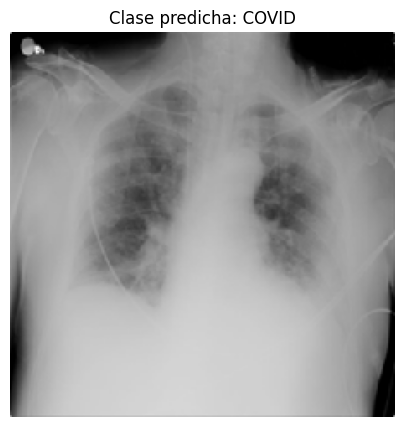

In [ ]:
# Aquí estoy cargando una imagen desde mi computadora y utilizando mi modelo entrenado (`model_2`) para predecir su clase.
# Primero, importo las librerías necesarias: NumPy para manejar arrays, Matplotlib para mostrar la imagen, y utilidades de Keras para trabajar con imágenes.
# Uso `files.upload()` para subir una imagen desde mi equipo, y si se sube correctamente, obtengo su nombre usando `uploaded.keys()`.
# Después, cargo la imagen con `load_img()` ajustándola al tamaño que mi modelo espera (224x224), y convierto la imagen en un array con `img_to_array()`.
# Expando las dimensiones del array con `expand_dims()` para que tenga el formato correcto que necesita el modelo (como si fuera un lote de imágenes).
# Hago la predicción con `model_2.predict()` y obtengo la clase con mayor probabilidad usando `argmax()`.
# Defino las etiquetas para mis clases ('COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia') y utilizo el índice obtenido para asignar la clase predicha.
# Por último, muestro la imagen usando Matplotlib y le pongo un título con la clase predicha, si no subo ninguna imagen, el código simplemente muestra un mensaje indicando que no se cargó nada.

# Y esto es para hacer todas las pruebas que se ven abajo pero con diferentes imagenes

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

if uploaded:

    imagen_path = list(uploaded.keys())[0]

    img = image.load_img(imagen_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predicciones = model_2.predict(img_array)
    clase_predicha_index = np.argmax(predicciones, axis=1)

    clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    clase_predicha = clases[clase_predicha_index[0]]

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Clase predicha: {clase_predicha}")
    plt.show()
else:
    print("No se subió ninguna imagen.")


Saving Normal-10.png to Normal-10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


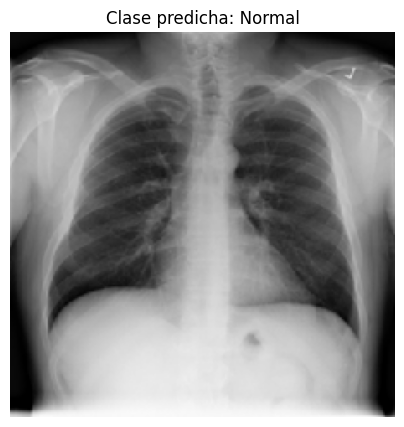

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

if uploaded:

    imagen_path = list(uploaded.keys())[0]

    img = image.load_img(imagen_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predicciones = model_2.predict(img_array)
    clase_predicha_index = np.argmax(predicciones, axis=1)

    clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    clase_predicha = clases[clase_predicha_index[0]]

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Clase predicha: {clase_predicha}")
    plt.show()
else:
    print("No se subió ninguna imagen.")


Saving Lung_Opacity-1004.png to Lung_Opacity-1004.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


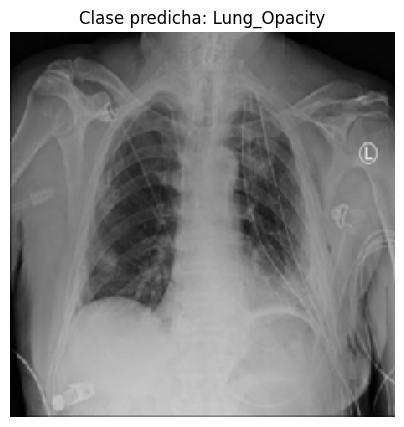

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()


if uploaded:

    imagen_path = list(uploaded.keys())[0]

    img = image.load_img(imagen_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predicciones = model_2.predict(img_array)
    clase_predicha_index = np.argmax(predicciones, axis=1)


    clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    clase_predicha = clases[clase_predicha_index[0]]


    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Clase predicha: {clase_predicha}")
    plt.show()
else:
    print("No se subió ninguna imagen.")


Saving Viral Pneumonia-1007.png to Viral Pneumonia-1007.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


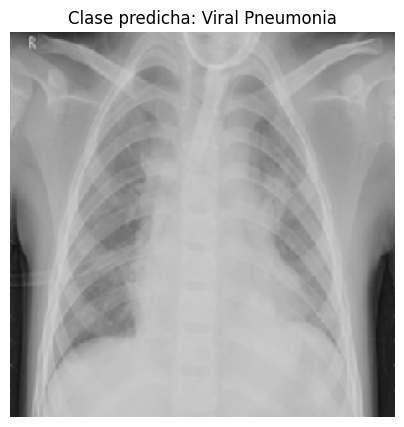

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

if uploaded:

    imagen_path = list(uploaded.keys())[0]

    img = image.load_img(imagen_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    predicciones = model_2.predict(img_array)
    clase_predicha_index = np.argmax(predicciones, axis=1)

    clases = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
    clase_predicha = clases[clase_predicha_index[0]]

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Clase predicha: {clase_predicha}")
    plt.show()
else:
    print("No se subió ninguna imagen.")


# **CONCLUSIÓN**

Mi modelo de clasificación basado en una red neuronal convolucional funciona de manera adecuada, cumpliendo con el objetivo de identificar correctamente las clases de imágenes dentro del dataset de radiografías, después de entrenar el modelo y evaluarlo con los datos de prueba, obtuve una precisión cercana al 89%, lo que demuestra que el modelo es capaz de generalizar bien sobre datos no vistos anteriormente, al realizar pruebas adicionales subiendo imágenes desde mi computadora, el modelo fue capaz de predecir la clase correcta con alta precisión, lo que confirma que la implementación es robusta y eficiente para este tipo de tareas de clasificación de imágenes médicas, en resumen, el modelo no solo muestra un buen rendimiento durante el entrenamiento, sino que también es fiable al ser utilizado en un entorno de producción para la clasificación de nuevas radiografías.

In [ ]:
model_2.save("model_2.keras")